### 使用说明
测试数据和更多使用方法请联系QQ群173640919，在群文件中有

In [79]:
import matplotlib.pyplot as plt 
%matplotlib inline 

In [80]:
import torch 
import torch.nn as nn 

In [81]:
from models.UNet import UNet, Loss as ULoss 
model = UNet() 
model.train()
model.load_state_dict(torch.load("ckpt/diting.unet.pt", map_location="cpu"))

<All keys matched successfully>

In [82]:
wave = torch.randn([100, 3, 6144])
y = model(wave)
print(y.shape)


torch.Size([100, 3, 6144])


### 数据读取部分
- windows系统建议使用Thread
- thread并行加速效果不明显

In [83]:
from utils.data import DitingData, DitingDataThread 

In [84]:
datatool = DitingDataThread(file_name="data/diting.h5", n_length=6144, stride=16, padlen=256)

In [85]:
x1, x2, x3, x4 = datatool.batch_data()
print(x1.shape, x2.shape, x3.shape, x4.shape)

(32, 3, 6144) (32, 2, 384) (32, 3, 6144) (32, 3, 6144)


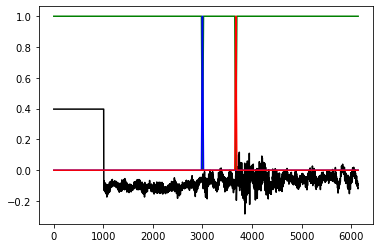

In [86]:
plt.plot(x1[0, 1], c="k")
plt.plot(x3[0, 0], c="g")
plt.plot(x3[0, 1], c="b")
plt.plot(x3[0, 2], c="r")

### 模型训练
- 将训练数据输入到模型中即可

In [87]:
from models.UNet import UNet, Loss as ULoss 
model = UNet() 
model.train()
model.load_state_dict(torch.load("ckpt/diting.unet.pt", map_location="cpu"))
lossfn = ULoss()
optim = torch.optim.Adam(model.parameters(), 1e-4) 

for step in range(10):
    x1, x2, x3, x4 = datatool.batch_data()
    wave = torch.tensor(x1, dtype=torch.float32)
    label = torch.tensor(x3, dtype=torch.float32) 
    y = model(wave)
    loss = lossfn(y, label)
    loss.backward() 
    optim.step()
    optim.zero_grad()
    if step %2==0:
        print(step, loss)
        torch.save(model.state_dict(), "ckpt/unet.temp.pt")

0 tensor(108845.4688, grad_fn=<NegBackward0>)
2 tensor(113183.4062, grad_fn=<NegBackward0>)
4 tensor(115453.3516, grad_fn=<NegBackward0>)
6 tensor(108292.7891, grad_fn=<NegBackward0>)
8 tensor(103311.4531, grad_fn=<NegBackward0>)


### 连续数据拾取

In [88]:
import torch 
jitmodel = torch.jit.load("ckpt/china.rnn.jit")

In [90]:
x = torch.randn([8640000, 3])
y = jitmodel(x)
print(y)

tensor([], size=(0, 3))


### 实际处理流程

In [91]:
import torch 
import torch.nn as nn 
from models.UNet import UNet 
class Picker(UNet):
    def __init__(self):
        super().__init__()
        self.n_stride = 1 
    def forward(self, x):
        device = x.device
        with torch.no_grad():
            #print("数据维度", x.shape)
            T, C = x.shape 
            seqlen = 6144 
            batchstride = 6144 - 256
            batchlen = torch.ceil(torch.tensor(T / batchstride).to(device))
            idx = torch.arange(0, seqlen, 1, device=device).unsqueeze(0) + torch.arange(0, batchlen, 1, device=device).unsqueeze(1) * batchstride 
            idx = idx.clamp(min=0, max=T-1).long()
            x = x.to(device)
            wave = x[idx, :] 
            wave = wave.permute(0, 2, 1)
            wave -= torch.mean(wave, dim=2, keepdim=True)
            max, maxidx = torch.max(torch.abs(wave), dim=2, keepdim=True) 
            wave /= (max + 1e-6)  
            x = wave.unsqueeze(3)
            x = self.inputs(x)
            x1 = self.layer0(x)
            x2 = self.layer1(x1)
            x3 = self.layer2(x2)
            x4 = self.layer3(x3)
            x5 = self.layer4(x4) 
            x6 = self.layer5(x5)
            x6 = torch.cat([x4, x6], dim=1) # 加入skip connection
            x7 = self.layer6(x6)
            x7 = torch.cat([x3, x7], dim=1) # 加入skip connection
            x8 = self.layer7(x7)
            x8 = torch.cat([x2, x8], dim=1) # 加入skip connection
            x9 = self.layer8(x8)
            x9 = torch.cat([x1, x9], dim=1) # 加入skip connection
            x10 = self.layer9(x9)
            x10 = x10.softmax(dim=1)
            oc = x10.squeeze(dim=3)
            B, C, T = oc.shape 
            tgrid = torch.arange(0, T, 1, device=device).unsqueeze(0) * self.n_stride + torch.arange(0, batchlen, 1, device=device).unsqueeze(1) * batchstride
            oc = oc.permute(0, 2, 1).reshape(-1, C) 
            ot = tgrid.squeeze()
            ot = ot.reshape(-1)
            output = []
            #print("NN处理完成", oc.shape, ot.shape)
            for itr in range(2):
                pc = oc[:, itr+1] 
                time_sel = torch.masked_select(ot, pc>0.3)
                score = torch.masked_select(pc, pc>0.3)
                _, order = score.sort(0, descending=True)    # 降序排列
                ntime = time_sel[order] 
                nprob = score[order]
                #print(batchstride, ntime, nprob)
                select = -torch.ones_like(order)
                selidx = torch.arange(0, order.numel(), 1, dtype=torch.long, device=device) 
                count = 0
                while True:
                    if nprob.numel()<1:
                        break 
                    ref = ntime[0]
                    idx = selidx[0]
                    select[idx] = 1 
                    count += 1 
                    selidx = torch.masked_select(selidx, torch.abs(ref-ntime)>1000)
                    nprob = torch.masked_select(nprob, torch.abs(ref-ntime)>1000)
                    ntime = torch.masked_select(ntime, torch.abs(ref-ntime)>1000)
                p_time = torch.masked_select(time_sel[order], select>0.0)
                p_prob = torch.masked_select(score[order], select>0.0)
                p_type = torch.ones_like(p_time) * itr 
                y = torch.stack([p_type, p_time, p_prob], dim=1)
                output.append(y) 
            y = torch.cat(output, dim=0)
        return y 

model = Picker() 
torch.jit.save(torch.jit.script(model), "unet.jit.temp")
x = torch.randn([300000, 3])
y = model(x) 
print(y)

tensor([[0.0000e+00, 1.5401e+05, 8.0958e-01],
        [0.0000e+00, 2.8136e+05, 8.0007e-01],
        [0.0000e+00, 2.1182e+05, 7.9768e-01],
        ...,
        [1.0000e+00, 1.9165e+05, 4.3951e-01],
        [1.0000e+00, 2.6985e+05, 3.6164e-01],
        [1.0000e+00, 2.8962e+05, 3.4502e-01]])
